# Section 3.3 — Introduction to hypothesis testing

This notebook contains the code examples from [Section 3.3 Introduction to hypothesis testing]() of the **No Bullshit Guide to Statistics**.

#### Notebook setup

In [1]:
# load Python modules
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Plot helper functions
from plot_helpers import nicebins
from plot_helpers import plot_pdf
from plot_helpers import savefigure


In [3]:
# Figures setup
plt.clf()  # needed otherwise `sns.set_theme` doesn't work
from plot_helpers import RCPARAMS
# RCPARAMS.update({'figure.figsize': (10, 3)})   # good for screen
RCPARAMS.update({'figure.figsize': (5, 1.6)})  # good for print
sns.set_theme(
    context="paper",
    style="whitegrid",
    palette="colorblind",
    rc=RCPARAMS,
)

# Useful colors
snspal = sns.color_palette()
blue, orange, purple = snspal[0], snspal[1], snspal[4]
# red = sns.color_palette("tab10")[3]

# High-resolution please
%config InlineBackend.figure_format = 'retina'

# Where to store figures
DESTDIR = "figures/stats/intro_to_NHST"

<Figure size 640x480 with 0 Axes>

In [4]:
# set random seed for repeatability
np.random.seed(42)

$\def\stderr#1{\mathbf{se}_{#1}}$
$\def\stderrhat#1{\hat{\mathbf{se}}_{#1}}$
$\newcommand{\Mean}{\textbf{Mean}}$
$\newcommand{\Var}{\textbf{Var}}$
$\newcommand{\Std}{\textbf{Std}}$
$\newcommand{\Freq}{\textbf{Freq}}$
$\newcommand{\RelFreq}{\textbf{RelFreq}}$
$\newcommand{\DMeans}{\textbf{DMeans}}$
$\newcommand{\Prop}{\textbf{Prop}}$
$\newcommand{\DProps}{\textbf{DProps}}$

$$
\newcommand{\CI}[1]{\textbf{CI}_{#1}}
\newcommand{\CIL}[1]{\textbf{L}_{#1}}
\newcommand{\CIU}[1]{\textbf{U}_{#1}}
\newcommand{\ci}[1]{\textbf{ci}_{#1}}
\newcommand{\cil}[1]{\textbf{l}_{#1}}
\newcommand{\ciu}[1]{\textbf{u}_{#1}}
$$


(this cell contains the macro definitions like $\stderr{\overline{\mathbf{x}}}$, $\stderrhat{}$, $\Mean$, ...)

## Definitions

In [5]:
def mean(sample):
    return sum(sample) / len(sample)

def var(sample):
    xbar = mean(sample)
    sumsqdevs = sum([(xi-xbar)**2 for xi in sample])
    return sumsqdevs / (len(sample)-1)

def std(sample):
    s2 = var(sample)
    return np.sqrt(s2)

def dmeans(xsample, ysample):
    dhat = mean(xsample) - mean(ysample)
    return dhat

### What is hypothesis testing?

- An approach to formulating research questions as **yes-no decisions** and a **procedure for making these decisions**
- Hypothesis testing is a standardized procedure for doing statistical analysis  
  (also, using stats jargon makes everything look more convincing ;)
- We formulate research question as two **competing hypotheses**:
  - **Null hypothesis $H_0$** = no effect.  
    In our example: "no difference between means," which can be written as $\color{red}{\mu_S = \mu_{NS} = \mu_0}$,
    means the probability models for the two groups have the same mean $\mu_0$:
    

  - **Alternative hypothesis $H_A$** = an effect exists.
    In our example: "the means for Group S is different from the mean of Group NS"
    can be written as $\color{blue}{\mu_S} \neq \color{orange}{\mu_{NS}}$.
    The probability models for the two groups with different means are:


- The purpose of hypothesis testing is to perform a basic sanity-check to show the difference between the group means
  we observed ($d = \overline{\mathbf{x}}_{S} - \overline{\mathbf{x}}_{NS} = 130$) is **unlikely to have occurred by chance**.
- NEW CONCEPT: the $p$-value is the probability of observing $d=130$ (or more extreme) under the null hypothesis.

## The logic of hypothesis testing

### Overview of the hypothesis testing procedure

Here is the high-level overview of the hypothesis testing procedure:
- **inputs**: sample statistics computed from the observed data
  (in our case the signal $\overline{\mathbf{x}}_S$, $\overline{\mathbf{x}}_{NS}$,
   and our estimates of the noise $s^2_S$, and $s^2_{NS}$)
- **outputs**: a decision that is one of: "reject the null hypothesis" or "fail to reject the null hypothesis"

![hypothesis testing overview](./attachments/stats/hypothesis_testing_perm_test.png)


We'll now look at two different approaches for computing the sampling distribution of
the difference between group means statistic, $D = \overline{\mathbf{X}}_S - \overline{\mathbf{X}}_{NS}$:
permutation tests and analytical approximations.

### Interpreting the result of a hypothesis test (optional)



- The implication of rejecting the null hypothesis (no difference) is that there must be a difference between the group means.
  In other words, the average ELV (employee lifetime value) for employees who took the statistics training (**Group S**) is different form
  the average ELV for employees who didn't take the statistics training (**Group NS**),
  which is what Amy is trying to show.
  - Note that rejecting null hypothesis ($H_0$) is not the same as "proving" the alternative hypothesis ($H_A$);
    we have just shown that the data is unlikely under the null hypothesis,
    so there must be *some* difference between the groups.
    The conclusion is that it's worth looking for *some* alternative hypothesis.
  - The alternative hypothesis we picked above, $\mu_S \neq \mu_{NS}$, is just a placeholder,
    that includes desirable effect: $\mu_S > \mu_{NS}$ (stats training improves ELV),
    but also includes the opposite effect: $\mu_S < \mu_{NS}$ (stats training decreases ELV).
  - Using statistics jargon, when we reject the hypothesis $H_0$ we say we've observed a "statistically significant" result,
    which sounds a lot more impressive than it actually is.
    The null hypothesis testing procedure is used to just rule out "occurred by chance" scenario,
    which is a very basic sanity check.    
- The implication of failing to reject the null hypothesis is that the observed difference
  between means is "not significant," meaning it could have occurred by chance,
  so there is no need to search for an alternative hypothesis.
  - Note that "failing to reject" is not the same as "proving" the null hypothesis.
  - Note also that "failing to reject $H_0$" doesn't mean we reject $H_A$.
    In fact, the alternative hypothesis didn't play any role in the calculations whatsoever.


I know all this sounds super complicated and roundabout (an it is!),
but you will get a hang of it with practice.
Trust me, you need to know this shit.


#### Selecting the tails of a distribution

The concept of statistics that are "equal or more extreme than" the observed statistic $\hat{\theta}=g(\mathbf{x})$
is essential to the logic of hypothesis testing.


In [6]:
#######################################################

def tailvalues(values, obs, alt="two-sided"):
    """
    Select the subset of the elements in list `values` that
    are equal or more extreme than the observed value `obs`.
    """
    assert alt in ["greater", "less", "two-sided"]
    values = np.array(values)
    if alt == "greater":
        tails = values[values >= obs]
    elif alt == "less":
        tails = values[values <= obs]
    elif alt == "two-sided":
        mean = np.mean(values)
        dev = abs(mean - obs)
        tails = values[abs(values-mean) >= dev]
    return tails

#### Right tail of the distribution

Given a list of observations from the sampling distribution `stats`,
we want to select the observations that are equal to or larger than the observed statistic `obs`.

In [7]:
stats = [-5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5]
obs = 2
tailvalues(stats, obs, alt="greater")

array([2, 3, 4, 5])

#### Left tail of the distribution

Given a list of observations from the sampling distribution `stats`,
we want to select the observations that are equal to or less than the observed statistic `obs`.

In [8]:
obs = -3
tailvalues(stats, -3, alt="less")

array([-5, -4, -3])

#### Both tails of the distribution

We select the observations that are equal to or more extreme than the deviation
of the observed statistic `obs`.
This means all values that are greater than `|obs|` and less than `-|obs|`.

In [9]:
obs = 4
tailvalues(stats, obs, alt="two-sided")

array([-5, -4,  4,  5])

Saved figure to figures/stats/intro_to_NHST/panel_hist_p-values_left_twotailed_right_tests.pdf
Saved figure to figures/stats/intro_to_NHST/panel_hist_p-values_left_twotailed_right_tests.png


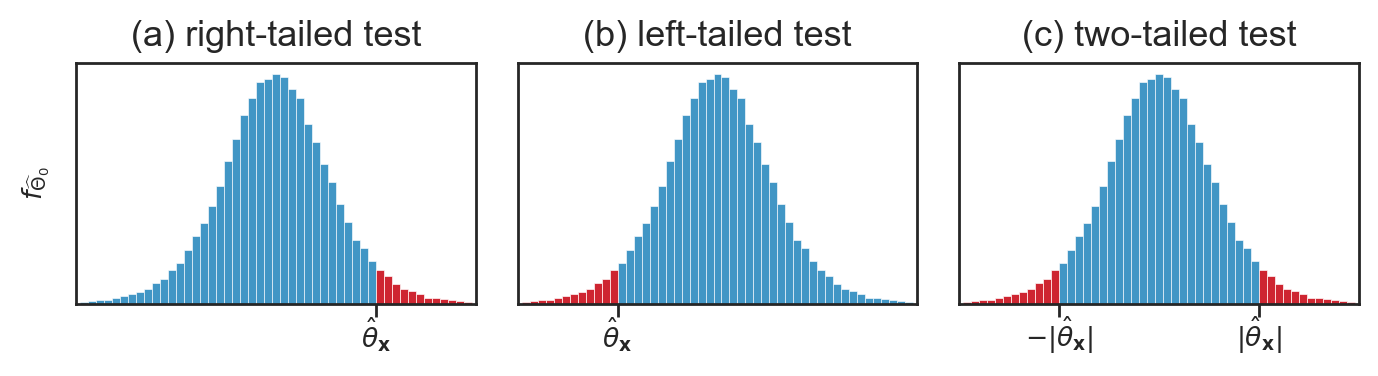

In [10]:
filename = os.path.join(DESTDIR, "panel_hist_p-values_left_twotailed_right_tests.pdf")
    
from scipy.stats import t as tdist
rvT = tdist(9)

xs = np.linspace(-4, 4, 1000)
ys = rvT.pdf(xs)

N = 100000
np.random.seed(42)
ts = rvT.rvs(N)

bins = nicebins(xs, 2, nbins=50)

with plt.rc_context({"figure.figsize":(7,2)}), sns.axes_style("ticks"):
    fig, (ax3, ax1, ax2) = plt.subplots(1, 3, sharey=True)
    ax3.set_ylabel("$f_{\widehat{\Theta}_0}$")

    # RIGHT
    title = '(a) right-tailed test'
    ax3.set_title(title, fontsize=13)
    sns.histplot(ts, ax=ax3, bins=bins)
    ax3.set_xlim(-4, 4)
    ax3.set_xticks([2])
    ax3.set_xticklabels([])
    ax3.set_yticks([])
    # highlight the right tail
    tailvalues3 = [t for t in ts if t >= 2]
    sns.histplot(tailvalues3, bins=bins, ax=ax3, color="red")
    ax3.text(2, -300, "$\hat{\\theta}_{\mathbf{x}}$", verticalalignment="top", horizontalalignment="center")
    
    # LEFT
    title = '(b) left-tailed test'
    ax1.set_title(title, fontsize=13)
    sns.histplot(ts, ax=ax1, bins=bins)
    
    ax1.set_xlim(-4, 4)
    ax1.set_xticks([-2])
    ax1.set_xticklabels([])
    ax1.set_yticks([])
    ax1.set_ylabel("")
    # highlight the left tail
    tailvalues1 = tailvalues(ts, -2, alt="less")
    sns.histplot(tailvalues1, bins=bins, ax=ax1, color="red")
    ax1.text(-2, -300, r"$\hat{\theta}_{\mathbf{x}}$", va="top", ha="center")

    # TWO-TAILED
    title = '(c) two-tailed test'
    ax2.set_title(title, fontsize=13)
    sns.histplot(ts, ax=ax2, bins=bins)
    ax2.set_xlim(-4, 4)
    ax2.set_xticks([-2,2])
    ax2.set_xticklabels([])
    ax2.set_yticks([])
    # highlight the left and right tails
    tailvalues2 = [t for t in ts if t <= -2 or t >= 2]
    sns.histplot(tailvalues2, bins=bins, ax=ax2, color="red")
    ax2.text(-2, -300, r"$-|\hat{\theta}_{\mathbf{x}}|$", verticalalignment="top", horizontalalignment="center")
    ax2.text(2, -300, r"$|\hat{\theta}_{\mathbf{x}}|$", verticalalignment="top", horizontalalignment="center")

savefigure(fig, filename)

Saved figure to figures/stats/intro_to_NHST/hist_p-value_right_tail_test.pdf
Saved figure to figures/stats/intro_to_NHST/hist_p-value_right_tail_test.png


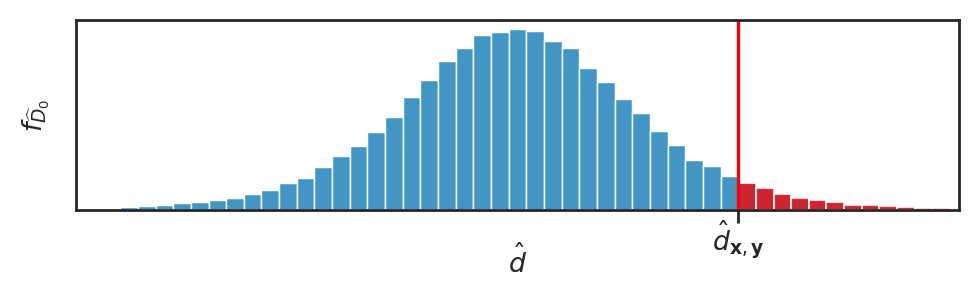

In [11]:
filename = os.path.join(DESTDIR, "hist_p-value_right_tail_test.pdf")

from scipy.stats import t as tdist
rvT = tdist(9)

xs = np.linspace(-4, 4, 1000)
ys = rvT.pdf(xs)

N = 100000
np.random.seed(42)
ts = rvT.rvs(N)

bins = nicebins(xs, 2, nbins=50)

with sns.axes_style("ticks"):
    fig, ax = plt.subplots()
    sns.histplot(ts, ax=ax, bins=bins)
    ax.set_xlabel("$\hat{d}$")
    ax.set_xlim(-4, 4)
    ax.set_xticks([2])
    ax.set_xticklabels([])
    ax.set_yticks([])
    ax.set_ylabel("$f_{\widehat{D}_0}$")
    # highlight the right tail
    tailvaluesa = [t for t in ts if t >= 2]
    sns.histplot(tailvaluesa, bins=bins, ax=ax, color="red")
    ax.text(2, -300, "$\hat{d}_{\mathbf{x},\mathbf{y}}$", verticalalignment="top", horizontalalignment="center")
    plt.axvline(2, color="red")

savefigure(fig, filename)

### Effect size estimates

EDITME

It's time to study Question 2, which is to estimate the *magnitude* of the change in ELV obtained from completing the stats training. We call this the *effect size* in statistics.

**effect size** is a measure of difference between intervention and control groups.

We want an answer to Question 2 (What is the estimated difference between group means?)
that takes into account the variability of the data.

**confidence interval** is a way to describe a range of values for an estimate
that takes into account the variability of the data.

We want to provide an answer to Question 2 in the form of a confidence interval that tells
us a range of values where we believe the true value of $\Delta$ falls.




#### Reminder on confidence intervals functions

In [12]:
from stats_helpers import ci_mean
from stats_helpers import ci_dmeans

## Simulation tests

Description of the problem: compare simple of obs. to an known population model

### Kombucha bottling process

Reminder of kombucha bottling scenario where 
theory: $K \sim \mathcal{N}(\mu_K=1000, \sigma_K=10)$


Computational approach: simulation given mu_0 and sigma_0 are known

### Example 1S: test for the mean of Batch 04

$$
    H_0: \;\; \mu = \mu_0 = 1000,
    \qquad \qquad
    H_A: \;\; \mu \neq \mu_0.
$$

In words,
the null hypothesis describes a regular batch,
where the mean of the batch is equal to the mean of the model $\mu_0=\mu_K=1000$.

We'll show the hypothesis testing procedure for
two different batches from the `kombucha` dataset.

In [13]:
kombucha = pd.read_csv("../datasets/kombucha.csv")
batch04 = kombucha[kombucha["batch"]==4]
ksample04 = batch04["volume"]

In [14]:
ksample04.count()

40

In [15]:
# observed mean
obsmean04 = mean(ksample04)
obsmean04

1003.8335

The mean volume calculated from the sample `ksample04` is $3.83$ ml higher than the expected mean $\mu_K = 1000$ ml.

Is this a big difference or not?

How likely is such deviation to occur by chance under the null hypothesis?

#### Sampling distribution under the null hypothesis

To answer this question,
we need to generate the sampling distribution of the mean
for samples of size $n=40$ under the null hypothesis $H_0$.
We can do this using the `gen_sampling_dist` function,
by providing it the probability model `rvK` $=K = \mathcal{N}(\mu_K=1000,\sigma_K=10)$,
which describes the variability of the kombucha volumes when the factory is operating correctly.

In [16]:
from scipy.stats import norm

# theoretical model for the kombucha volumes
muK = 1000   # population mean (expected kombucha volume)
sigmaK = 10  # population variance
rvK = norm(muK, sigmaK)

We can now generate the sampling distribution using simulation...

In [17]:
from stats_helpers import gen_sampling_dist

np.random.seed(42)
kbars40 = gen_sampling_dist(rvK, estfunc=mean, n=40)

To calculate the $p$-value, we want
want to calculate how many values of sampling distribution `kbars40`
are equal or more extreme than the observed value $\overline{\mathbf{k}}_{04} = $ `obsmean04` = 1003.8335.

In [18]:
tails = tailvalues(kbars40, obsmean04)
pvalue04 = len(tails) / len(kbars40)
pvalue04

0.015

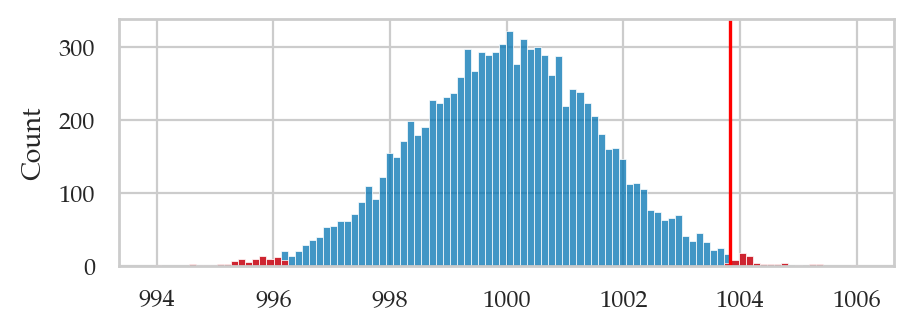

In [19]:
# plot the sampling distribution as a histogram
sns.histplot(kbars40, bins=100)

# plot red line for the observed mean
plt.axvline(obsmean04, color="red")

# plot the values that are equal or more extreme in red
_ = sns.histplot(tails, bins=100, color="red")

Saved figure to figures/stats/intro_to_NHST/hist_p-value_kombucha_obsmean04.pdf
Saved figure to figures/stats/intro_to_NHST/hist_p-value_kombucha_obsmean04.png


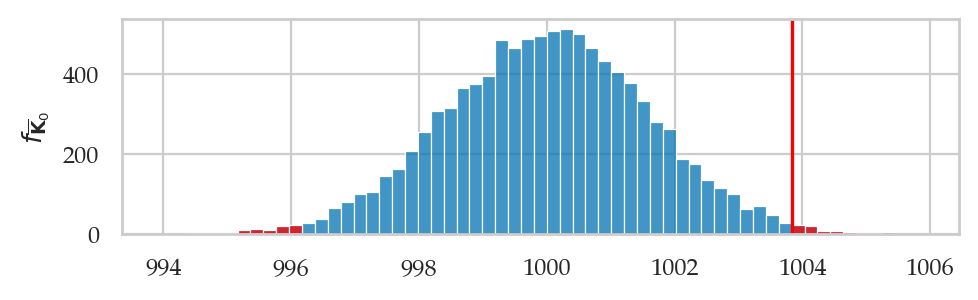

In [20]:
filename = os.path.join(DESTDIR, "hist_p-value_kombucha_obsmean04.pdf")

# plot the sampling distribution as a histogram
bins = nicebins(kbars40, obsmean04)
ax = sns.histplot(kbars40, bins=bins)

# plot red line for the observed statistic
plt.axvline(obsmean04, color="red")

# plot the values that are equal or more extreme in red
sns.histplot(tails, bins=bins, ax=ax, color="red")
ax.set_ylabel("$f_{\overline{\mathbf{K}}_0}$")

savefigure(ax, filename)

We can now make the decision based on the $p$-value and a pre-determined threshold,
which is conventionally chosen $\alpha=0.05$ (1 in 20):

- If the observed value of the mean `obsmean04` = 1003.8335 is unlikely under
  $H_0$ ($p$-value less than 5% chance of occurring),
  then our decision will be to "reject the null hypothesis."
- Otherwise, if the observed value `obsmean04` is not that unusual ($p$-value greater than 5%),
  we conclude that we have "fail to reject the null hypothesis."

Recall the math statement of the null hypothesis is $H_0: \mu = \mu_K = 1000$,
which describes a batch whose mean is equal to the mean of the model $\mu_K$.
The conclusion to reject $H_0$ means the batch is irregular.

#### Effect size estimates

We were able to detect that batch differs from the expected distribution,
but how big is this deviation?
We can use the deviation from the expected mean as measure of the effect size $\Delta = \overline{\mathbf{k}} - \mu_K$ in this situation.

In [21]:
mean(ksample04) - muK

3.833499999999958

The point estimate $\Delta = \overline{\mathbf{k}} - \mu_K = 3.83$
tells us how much the mean of the sample differs from the expected population mean $\mu_K$,
but doesn't tell us the uncertainty in this estimate.

The bootstrap confidence interval for the effect size 
$\ci{\Delta,0.9}^*$ tells us a range of plausible values for the effect size.

In [22]:
from stats_helpers import gen_boot_dist

np.random.seed(48)
D_boot = gen_boot_dist(ksample04-muK, estfunc=mean)
[np.percentile(D_boot, 5),
 np.percentile(D_boot, 95)]

[1.7537499999999935, 5.802025000000007]

The function `ci_mean` that we defined earlier performs the exact same operation,
when called with the argument `method="b"`.

In [23]:
np.random.seed(48)
ci_mean(ksample04-muK, alpha=0.1, method="b")

[1.7537499999999935, 5.802025000000007]

The confidence interval $\ci{\Delta,0.9}^* = [1.75, 5.80]$ tells us the true discrepancy
of Batch 04 from the expected mean can be anywhere from 1.75 to 5.8.

### Example 2S: test for the mean of Batch 01

Let's repeat the procedure on the sample 

In [24]:
batch01 = kombucha[kombucha["batch"]==1]
ksample01 = batch01["volume"]
ksample01.count()

40

In [25]:
obsmean01 = mean(ksample01)
obsmean01

999.10375

In [26]:
np.random.seed(42)
kbars40 = gen_sampling_dist(rvK, estfunc=mean, n=40)
tails = tailvalues(kbars40, obsmean01)
pvalue01 = len(tails) / len(kbars40)
pvalue01

0.5708

The observed mean from batch 01 is not unlikely under $H_0$,
so we conclude that Batch 01 is a regular batch.

Using the terminology of hypothesis testing,
we say the outcome of the hypothesis test is "fail to reject $H_0: \mu = \mu_K$."
We have not seen any evidence that suggests that the mean of the population from
which sample `ksample01` was taken differs from the mean of the expected model $K$.

Ship it!

Saved figure to figures/stats/intro_to_NHST/hist_p-value_kombucha_obsmean01.pdf
Saved figure to figures/stats/intro_to_NHST/hist_p-value_kombucha_obsmean01.png


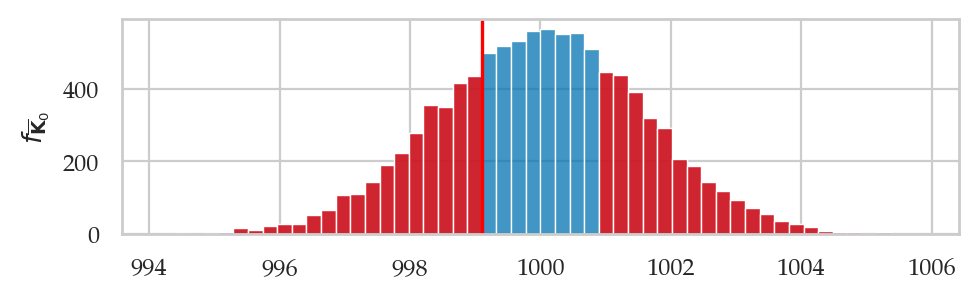

In [27]:
filename = os.path.join(DESTDIR, "hist_p-value_kombucha_obsmean01.pdf")

# plot the sampling distribution as a histogram
bins = nicebins(kbars40, obsmean01)
ax = sns.histplot(kbars40, bins=bins)

# plot red line for the observed statistic
plt.axvline(obsmean01, color="red")

# plot the values that are equal or more extreme in red
sns.histplot(tails, bins=bins, ax=ax, color="red")
ax.set_ylabel("$f_{\overline{\mathbf{K}}_0}$")

savefigure(ax, filename)

### Reusable test function for the mean

In [28]:
#######################################################

def simulation_test_mean(sample, mu0, sigma0, N=10000):
    """
    Compute the p-value of the observed mean of `sample`
    under H0 of a normal distribution `norm(mu0,sigma0)`.
    """
    # Compute the observed value of the mean
    obsmean = mean(sample)
    n = len(sample)

    # Get sampling distribution of the mean under H0
    rvXH0 = norm(mu0, sigma0)
    xbars = gen_sampling_dist(rvXH0, estfunc=mean, n=n)

    # Compute the p-value
    tails = tailvalues(xbars, obsmean)
    pvalue = len(tails) / len(xbars)
    return pvalue

In [29]:
## TEST 1 (Do we get the same answer for Batch 04?)
np.random.seed(42)
simulation_test_mean(ksample04, mu0=muK, sigma0=sigmaK)

0.015

In [30]:
## TEST 2 (Do we get the same answer for Batch 01?)
np.random.seed(42)
simulation_test_mean(ksample01, mu0=muK, sigma0=sigmaK)

0.5708

### Example 3S: test for the variance of Batch 02

Let's now assume the sample of volume measurements $\mathbf{k}_{02}$ from the Batch~02 of the kombucha bottling plant, 
comes from a population with unknown variance $\sigma^2$,
which we can estimate by computing the sample variance $s^2_{\mathbf{k}_{02}}$.

We want to check whether Batch~02 is a "regular" or "irregular" by comparing the variance in the volumes
of this batch $\sigma^2$ to the variance of the theoretical model $\sigma_K^2= 100$.
Specifically,
we're interested in detecting the case when the variance is higher than expected:

$$
    H_0: \;\; \sigma^2 \leq \sigma_K^2,
    \qquad \qquad
    H_A: \;\; \sigma^2 > \sigma_K^2.
$$

Note the alternative hypothesis detects the "greater than" inequality,
since we don't mind batches with very low variance.

In [31]:
kombucha = pd.read_csv("../datasets/kombucha.csv")
batch02 = kombucha[kombucha["batch"]==2]
ksample02 = batch02["volume"]
ksample02.count()

20

In [32]:
obsvar02 = var(ksample02)
obsvar02

124.31760105263136

In [33]:
np.random.seed(42)
kvars20 = gen_sampling_dist(rvK, estfunc=var, n=20)
tails = tailvalues(kvars20, obsvar02, alt="greater")
pvalue = len(tails) / len(kvars20)
pvalue

0.2132

Saved figure to figures/stats/intro_to_NHST/hist_p-value_kombucha_obsvar02.pdf
Saved figure to figures/stats/intro_to_NHST/hist_p-value_kombucha_obsvar02.png


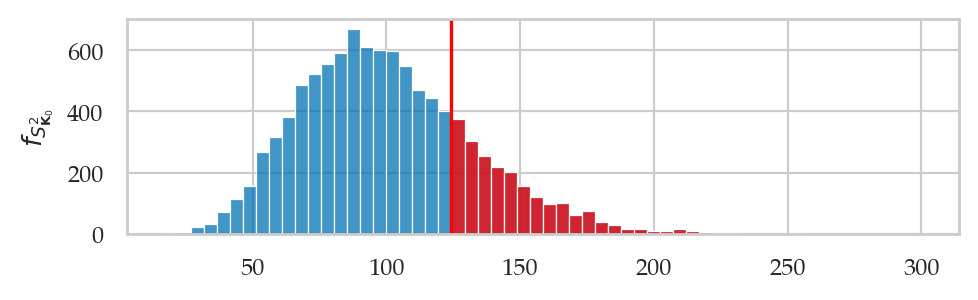

In [34]:
filename = os.path.join(DESTDIR, "hist_p-value_kombucha_obsvar02.pdf")

# plot the sampling distribution as a histogram
bins = nicebins(kvars20, obsvar02)
ax = sns.histplot(kvars20, bins=bins)

# plot red line for the observed statistic
plt.axvline(obsvar02, color="red")

# plot the values that are equal or more extreme in red
sns.histplot(tails, bins=bins, ax=ax, color="red")
ax.set_ylabel("$f_{S^2_{\mathbf{K}_0}}$")

savefigure(ax, filename)

### Example 4S: test for the variance of Batch 08

In [35]:
kombucha = pd.read_csv("../datasets/kombucha.csv")
batch08 = kombucha[kombucha["batch"]==8]
ksample08 = batch08["volume"]
ksample08.count()

40

In [36]:
obsvar08 = var(ksample08)
obsvar08

169.9979220512824

#### Sampling distribution under the null hypothesis

In [37]:
np.random.seed(43)
kvars40 = gen_sampling_dist(rvK, estfunc=var, n=40)
tails = tailvalues(kvars40, obsvar08, alt="greater")
pvalue = len(tails) / len(kvars40)
pvalue

0.0041

Saved figure to figures/stats/intro_to_NHST/hist_p-value_kombucha_obsvar08.pdf
Saved figure to figures/stats/intro_to_NHST/hist_p-value_kombucha_obsvar08.png


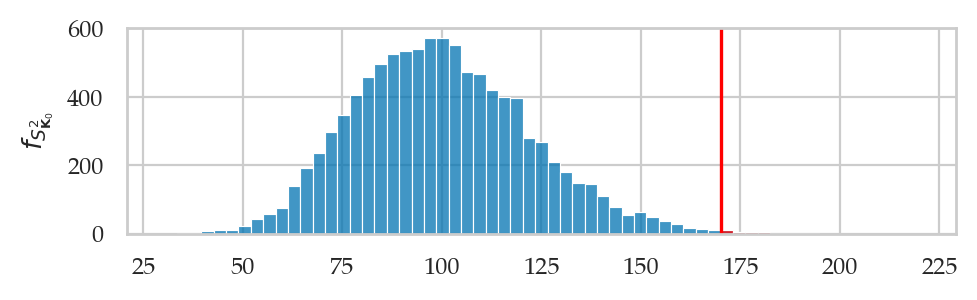

In [38]:
filename = os.path.join(DESTDIR, "hist_p-value_kombucha_obsvar08.pdf")

# plot the sampling distribution as a histogram
bins = nicebins(kvars40, obsvar08)
ax = sns.histplot(kvars40, bins=bins)

# plot red line for the observed statistic
plt.axvline(obsvar08, color="red")

# plot the values that are equal or more extreme in red
sns.histplot(tails, bins=bins, ax=ax, color="red")
ax.set_ylabel("$f_{S^2_{\mathbf{K}_0}}$")

savefigure(ax, filename)

#### Effect size estimates

We found the variance in the volumes in this batch is higher than the expected variance.
Now let's estimate the effect size $\Delta = s^2_{\mathbf{k}_{08}} - \sigma_K^2$.

In [39]:
var(ksample08) - sigmaK**2

69.99792205128239

The bootstrap confidence interval for the effect size 
$\ci{\Delta,0.9}^*$ tells us a range of plausible values for the effect size.

In [40]:
from stats_helpers import gen_boot_dist

np.random.seed(48)
kvars40_boot = gen_boot_dist(ksample08, estfunc=var)
D_boot = np.subtract(kvars40_boot, sigmaK**2)
[np.percentile(D_boot, 5),
 np.percentile(D_boot, 95)]

[17.37369362820536, 117.98659930448775]

The interval $\ci{\Delta,0.9}^* = [17, 118]$ tells us the difference
in the variance of Batch 08 from the expected variance is somewhere between 17 and 118.

### Generic simulation test function

In [41]:
#######################################################

def simulation_test_var(sample, mu0, sigma0, alt="greater"):
    """
    Compute the p-value of the observed variance of `sample`
    under H0 of a normal distribution `norm(mu0,sigma0)`.
    """
    # 1. Compute the sample variance
    obsvar = var(sample)
    n = len(sample)

    # 2. Get sampling distribution of variance under H0
    rvXH0 = norm(mu0, sigma0)
    xvars = gen_sampling_dist(rvXH0, estfunc=var, n=n)

    # 3. Compute the p-value
    tails = tailvalues(xvars, obsvar, alt=alt)
    pvalue = len(tails) / len(xvars)
    return pvalue

In [42]:
# reproduce the results from Example 3
np.random.seed(42)
simulation_test_var(ksample02, muK, sigmaK, alt="greater")

0.2132

In [43]:
# reproduce the results from Example 4
np.random.seed(43)
simulation_test_var(ksample08, muK, sigmaK, alt="greater")

0.0041

## Analytical approximation tests

### Formula for sampling distribution of the mean

Reminder of kombucha bottling scenario where 
theory: $K \sim \mathcal{N}(1000,10)$, samples: ⑤ kombucha

In [44]:
muK = 1000
sigmaK = 10

### Analytical approximation for sample mean

In [45]:
# norm

### Example 1N: test for the mean of Batch 04

In [46]:
kombucha = pd.read_csv("../datasets/kombucha.csv")
batch04 = kombucha[kombucha["batch"]==4]
ksample04 = batch04["volume"]
n04 = len(ksample04)

# observed mean
obsmean04 = mean(ksample04)
obsmean04

1003.8335

#### Assume we know complete model

In [47]:
from scipy.stats import norm

# standard error of the mean
se = sigmaK / np.sqrt(n04)

# compute the z statistic 
obsz = (obsmean04 - muK) / se
obsz

2.42451828205107

In [48]:
from scipy.stats import norm
rvZ = norm(0,1)
pvalue = 2 * (1 - rvZ.cdf(obsz))
pvalue

0.015328711497996528

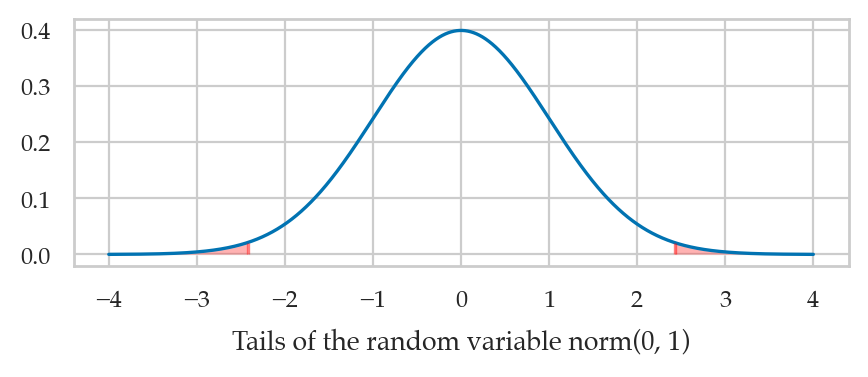

In [49]:
from plot_helpers import calc_prob_and_plot_tails
_ = calc_prob_and_plot_tails(rvZ, -obsz, obsz, xlims=[-4,4])

### Example 2N: test for the mean of Batch 01

In [64]:
# TODO

### Formula for sampling distribution of the variance

#### Chi-square test for variance

see also:
 - https://www.itl.nist.gov/div898/handbook/eda/section3/eda358.htm
 - https://openpress.usask.ca/introtoappliedstatsforpsych/chapter/9-5-chi-squared-test-for-variance-or-standard-deviation/


### Example 3X: test for the variance of Batch 02

In [50]:
kombucha = pd.read_csv("../datasets/kombucha.csv")
batch02 = kombucha[kombucha["batch"]==2]
ksample02 = batch02["volume"]
n02 = ksample02.count()
n02

20

In [51]:
obsvar02 = var(ksample02)
obsvar02

124.31760105263136

In [52]:
obschi2 = (n02-1) * obsvar02 / sigmaK**2
obschi2

23.62034419999996

In [53]:
from scipy.stats import chi2

df = n02 - 1
rvX2 = chi2(df)

pvalue = 1 - rvX2.cdf(obschi2)
pvalue

0.2111207328360385

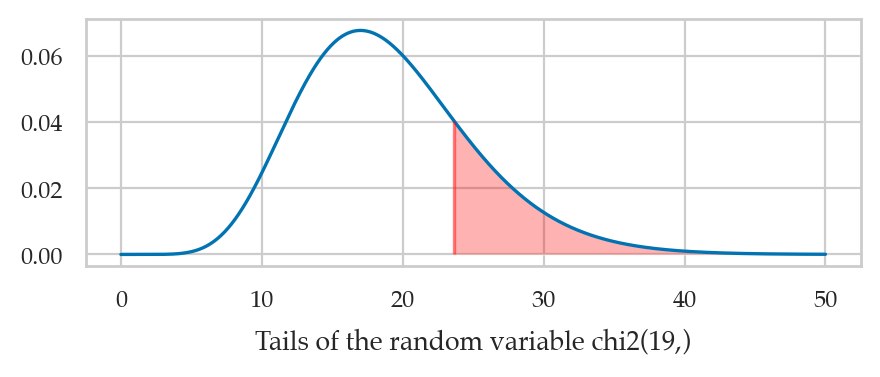

In [54]:
# plot tails
_ = calc_prob_and_plot_tails(rvX2, 0, obschi2, xlims=[0,50])

### Example 4X: test for the variance of Batch 08

In [55]:
# TODO: ksample08


## Tests with estimated population variance

### Analytical approximation based on Student's $t$-distribution

### Example 1T: test for the mean of Batch 04

#### Assume we know mean, but not variance

In [56]:
# estimated standard error of the mean
s04 = std(ksample04)
sehat = s04 / np.sqrt(n04)

# compute the t statistic 
obst = (obsmean04 - muK) / sehat
obst

3.087703149420272

In [57]:
from scipy.stats import t as tdist

df = n04 - 1  # n-1 degrees of freedom
rvT = tdist(df)
pvalue = 2 * (1 - rvT.cdf(obst))
pvalue

0.0037056653503328985

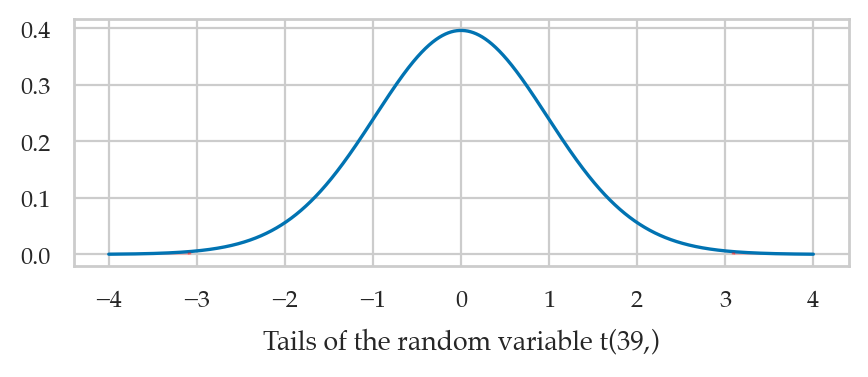

In [58]:
_ = calc_prob_and_plot_tails(rvT, -obst, obst, xlims=[-4,4])

In [59]:
# ALT. using existing function `scipy.stats`
from scipy.stats import ttest_1samp
ttest_1samp(ksample04, popmean=1000).pvalue

0.0037056653503329618

### Example 2T: test for the mean of Batch 01

In [66]:
# TODO

### Bootstrap estimate of the standard error

### Example 1BT: test for the mean of Batch 04

In [ ]:
# TODO

### Example 2BT: test for the mean of Batch 01

In [65]:
# TODO

## Explanations

### Statistical modelling and assumptions

### Two different probability models

### One-sided and two-sided tests

### Court trial analogy

## Discussion

### Problems with hypothesis testing

In [60]:
##########a#############################################
def getdecision(pvalue, alpha=0.05):
    """
    Check if `pvalue` is less than or equal to `alpha`.
    """
    if pvalue < alpha:
        # The observed statistics is unlikely to have
        # occurred under the null hypothesis
        print("reject H0")
    else:
        # The observed statistics could have occurred
        # under the null hypothesis
        print("fail to reject H0")

### Standardized effect size

It is sometimes useful to report the effect size using a "standardized" measure for effect sizes.

Cohen's $d$ is one such measure, and it is defined as the difference between two means divided by the pooled standard deviation.

In [61]:
def cohend(sample, mu):
    """
    Cohen's d for one group compared to the theoretical mean `mu`.
    """
    obsmean = mean(sample)
    obsstd = std(sample)
    cohend = (obsmean - mu) / obsstd
    return cohend

We can interpret the value of Cohen's d obtained using the [reference table](https://en.wikipedia.org/wiki/Effect_size#Cohen's_d) of values:

| Cohen's d   | Effect size |
| ----------- | ----------- |
| 0.01        | very small  |
| 0.20        | small       |
| 0.50        | medium      |
| 0.80        | large       |


Effect size for mean deviation of kombucha Batch 04 from expected value $\mu_K=1000$.

In [62]:
cohend(ksample04, mu=1000)

0.4882087345321637

Effect size for the difference between electricity prices.

## Exercises

In [63]:
# TODO

## Links

* [The Introductory Statistics Course: A Ptolemaic Curriculum](https://minireference.com/blog/wp-content/uploads/2021/03/TheIntroductoryStatisticsCourse__Cobb.pdf) by George W. Cobb
* [Permutation Methods: A Basis for Exact Inference](https://projecteuclid.org/journals/statistical-science/volume-19/issue-4/Permutation-Methods-A-Basis-for-Exact-Inference/10.1214/088342304000000396.full) by Michael D. Ernst
* [What Teachers Should Know About the Bootstrap: Resampling in the Undergraduate Statistics Curriculum](https://www.tandfonline.com/doi/full/10.1080/00031305.2015.1089789) by Tim C. Hesterberg  
* \[BOOK\] [Think Stats 2e](https://greenteapress.com/wp/think-stats-2e/) by Allen B. Downey  
* \[VIDEO\] [There's Only One Test](https://www.youtube.com/watch?v=S41zQEshs5k) by Allen B. Downey
* \[TALK\] [Statistics for Hackers](https://www.youtube.com/watch?v=Iq9DzN6mvYA) by Jake Vanderplas


New links:

* Nice animation https://commons.wikimedia.org/wiki/File:Permutation_test_example_animation.gif  
  via https://en.wikipedia.org/wiki/Permutation_test

# Imported stuff from overview